# CNNGeometric demo notebook (Tensorflow)
This notebook shows how to run a trained model on a given image pair

## Imports

In [1]:
import os
import argparse
import tensorflow as tf
# from torch.utils.data import Dataset, DataLoader
from model.cnn_geometric_model_complete import CNNGeometric
from data.pf_dataset_complete import PFDataset
from data.download_datasets_complete import download_PF_willow
from image.normalization_complete import NormalizeImageDict, normalize_image
from util.tf_util_complete import BatchTensorToVars, str_to_bool
from geotnf.transformation_complete import GeometricTnf
from geotnf.point_tnf_complete import *
import matplotlib.pyplot as plt
from skimage import io
import warnings
from collections import OrderedDict

warnings.filterwarnings('ignore')


## Parameters

In [2]:
feature_extraction_cnn = 'resnet_v2'

"""
if feature_extraction_cnn=='vgg':
    model_aff_path = 'trained_models/best_pascal_checkpoint_adam_affine_grid_loss.pth.tar'
    model_tps_path = 'trained_models/best_pascal_checkpoint_adam_tps_grid_loss.pth.tar'
elif feature_extraction_cnn=='resnet_v2':
    model_aff_path = 'trained_models/best_pascal_checkpoint_adam_affine_grid_loss_resnet_random.pth.tar'
    model_tps_path = 'trained_models/best_pascal_checkpoint_adam_tps_grid_loss_resnet_random.pth.tar'   
"""

source_image_path='toy_data/industrial.jpg'
target_image_path='toy_data/industrial_r.jpg'

## Load models

In [3]:
# Create model
print('Creating CNN model...')
model_aff = CNNGeometric(feature_extraction_cnn=feature_extraction_cnn)

"""
# Load trained weights
print('Loading trained model weights...')
if do_aff:
    checkpoint = torch.load(model_aff_path, map_location=lambda storage, loc: storage)
    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
    model_aff.load_state_dict(checkpoint['state_dict'])
if do_tps:
    checkpoint = torch.load(model_tps_path, map_location=lambda storage, loc: storage)
    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
    model_tps.load_state_dict(checkpoint['state_dict'])
"""

Creating CNN model...


"\n# Load trained weights\nprint('Loading trained model weights...')\nif do_aff:\n    checkpoint = torch.load(model_aff_path, map_location=lambda storage, loc: storage)\n    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])\n    model_aff.load_state_dict(checkpoint['state_dict'])\nif do_tps:\n    checkpoint = torch.load(model_tps_path, map_location=lambda storage, loc: storage)\n    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])\n    model_tps.load_state_dict(checkpoint['state_dict'])\n"

## Create image transformers

In [4]:
affTnf = GeometricTnf(geometric_model='affine')

## Load and preprocess images

In [5]:
resizeCNN = GeometricTnf(out_h=240, out_w=240) 
#normalizeTnf = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def preprocess_image(image):
    # convert to TF Variable
    image = tf.expand_dims(image,0)
    image = tf.Variable(tf.cast(image,'float32')/255.0)
    image_var = tf.Variable(image,trainable=False)

    # Resize image using bilinear sampling with identity affine tnf
    image_var = resizeCNN(image_var)
    
    # Normalize image
    image_var = normalize_image(image_var)
    
    return image_var

In [6]:
source_image = io.imread(source_image_path)
target_image = io.imread(target_image_path)

source_image_var = preprocess_image(source_image)
target_image_var = preprocess_image(target_image)

batch = {'source_image': source_image_var, 'target_image':target_image_var}

resizeTgt = GeometricTnf(out_h=target_image.shape[0], out_w=target_image.shape[1]) 

Instructions for updating:
Use the `axis` argument instead


## Evaluate model

In [7]:
"""
if do_aff:
        model_aff.eval()
if do_tps:
    model_tps.eval()
"""

# Evaluate models
theta_aff=model_aff(batch)
warped_image_aff = affTnf(batch['source_image'], tf.reshape(theta_aff, [-1,2,3]))

## Process result

In [8]:
# Un-normalize images and convert to numpy

warped_image_aff_np = normalize_image(resizeTgt(warped_image_aff),forward=False)
warped_image_aff_np = tf.squeeze(warped_image_aff_np, 0)
#warped_image_aff_np = tf.transpose(warped_image_aff_np,[2,0,1])

#warped_image_aff_np = tf.image.encode_jpeg(tf.cast(warped_image_aff_np, tf.uint8))

sess = tf.Session()
sess.run(tf.global_variables_initializer())
warped_image_aff_np = sess.run(warped_image_aff_np)
print(warped_image_aff_np.shape)

(684, 684, 3)


## Display

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


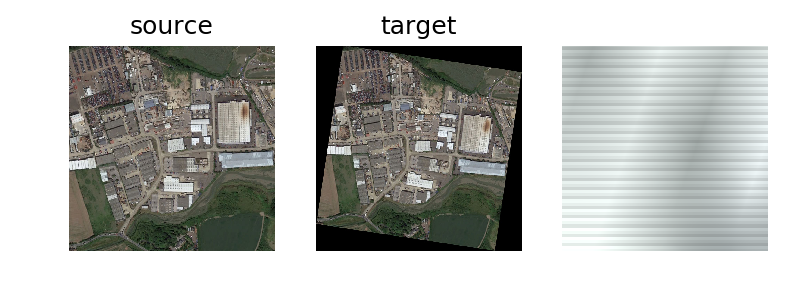

In [9]:
N_subplots =3
fig, axs = plt.subplots(1,N_subplots)
axs[0].imshow(source_image)
axs[0].set_title('source')
axs[1].imshow(target_image)
axs[1].set_title('target')
subplot_idx = 2

axs[subplot_idx].imshow(warped_image_aff_np)
axs[subplot_idx].set_title('')
subplot_idx +=1 


for i in range(N_subplots):
    axs[i].axis('off')

fig.set_dpi(150)
plt.show()

TODO : pretrained weight 가져오기...